In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [5]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [6]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [7]:
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask
T2 = ds['T2'].groupby('XTIME.day').mean().values*seamask

LHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/LHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(LHF_file) # gia fatto ritaglio lonlat
LHF_coare = ds_tmp['LHF'].values*seamask
del ds_tmp

SHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/SHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(SHF_file) # gia fatto ritaglio lonlat
SHF_coare = ds_tmp['SHF'].values*seamask
del ds_tmp

In [14]:
s = 'inf'

dsst_day = np.zeros(sst_day.shape)
dT2 = dsst_day.copy()
dLHF = dsst_day.copy()
dSHF = dsst_day.copy()

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave
    
    T2_ave = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - T2_ave
    
    lhf_ave = gm.nan_gaussian_filter(LHF_coare[t],s)                             
    dLHF[t] = LHF_coare[t] - lhf_ave
    
    shf_ave = gm.nan_gaussian_filter(SHF_coare[t],s)                             
    dSHF[t] = SHF_coare[t] - shf_ave
    

0
10
20


In [34]:
fourier_large = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced_LARGE.npy')
fou_01 = np.ones_like(fourier_large)
fou_01[fourier_large != 1.] = 0

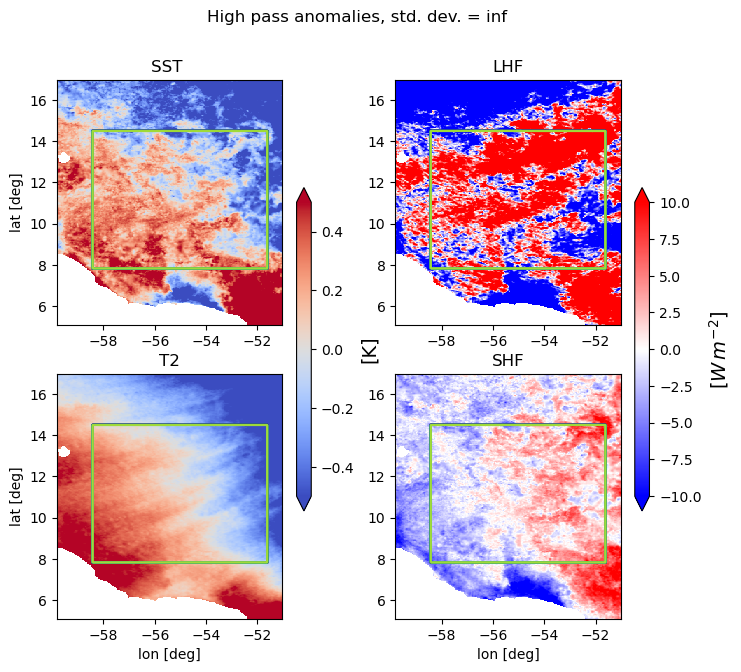

In [36]:
day = int(5)
fig, ax = plt.subplots(2,2, figsize=(8,7))
fig.suptitle(f'High pass anomalies, std. dev. = {s}')

ax[0, 0].pcolormesh(lon, lat, (dsst_day[day]), cmap='coolwarm', vmin=-0.5, vmax=0.5  )
ax[0,0].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[0, 0].set_ylabel('lat [deg]')
ax[0, 0].set_title('SST ')


mesh_anoms= ax[1,0].pcolormesh(lon, lat, (dT2[day]), cmap='coolwarm', vmin=-0.5, vmax=0.5  )
ax[1,0].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[1,0].set_title('T2')
ax[1,0].set_ylabel('lat [deg]')
ax[1,0].set_xlabel('lon [deg]')

cbar_anoms = plt.colorbar(mesh_anoms, ax=ax[:,0], location='right', extend='both', shrink=0.6)
cbar_anoms.set_label('[K]', fontsize=14)



ax[0,1].pcolormesh(lon, lat, (dLHF[day]), cmap='bwr', vmin=-10., vmax=10.  )
ax[0,1].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[0,1].set_title(r'LHF')
# ax[0,1].set_ylabel('lat [deg]')


mesh_anoms=ax[1,1].pcolormesh(lon, lat, (dSHF[day]), cmap='bwr', vmin=-10., vmax=10.  )
ax[1,1].contour(lon, lat, fou_01, levs=[0.9, 1.1])
ax[1,1].set_title(r'SHF')
# ax[1,1].set_ylabel('lat [deg]')
ax[1,1].set_xlabel('lon [deg]')


cbar_anoms = plt.colorbar(mesh_anoms, ax=ax[:,1], location='right', extend='both', shrink=0.6)
cbar_anoms.set_label(r'[$W\,m^{-2}$]', fontsize=14)


# plt.tight_layout()§